# Preprocesamiento del datasets COVID

In [120]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from openpyxl import load_workbook, Workbook

In [121]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

## Inspección de los datos

### Cargar datos

In [122]:
# Path al archivo
file_path ='../../data/raw/COVID19MEXICO.parquet'
# Cargar archivo CSV como DataFrame
df = pd.read_parquet(file_path)
# Inspeccionar primeros elementos del DataFrame
df.head()

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  SECTOR  ENTIDAD_UM  SEXO  \
0          2024-04-23      c9a5ed       2      12           9     2   
1          2024-04-23      cbecc9       2       6           5     1   
2          2024-04-23      1b6d59       1      12           9     1   
3          2024-04-23      0ed066       2      12          16     2   
4          2024-04-23      7aeb5d       2      12           3     1   

   ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES  TIPO_PACIENTE  ... OTRO_CASO  \
0            9            9              9              1  ...         2   
1            5            5             28              1  ...         2   
2            9            9             12              1  ...         1   
3           16           16             41              1  ...         2   
4           15            3              3              1  ...         1   

  TOMA_MUESTRA_LAB RESULTADO_LAB  TOMA_MUESTRA_ANTIGENO  RESULTADO_ANTIGENO  \
0                2            97                      1                   2   
1                2            97                      1                   2   
2                2            97                      1                   1   
3                2            97                      1                   2   
4                2            97                      1                   2   

   CLASIFICACION_FINAL  MIGRANTE  PAIS_NACIONALIDAD  PAIS_ORIGEN  UCI  
0                    7        99             México           97   97  
1                    7        99             México           97   97  
2                    3        99             México           97   97  
3                    7        99             México           97   97  
4                    7        99             México           97   97  

[5 rows x 40 columns]

### Dimensiones de los datos

In [123]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df.shape}\n")

Dimensión de los datos: (1296717, 40)



### Columnas

In [124]:
# Inspeccionar el nombre de las columnas
df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

### Valores faltantes

In [125]:
print(f"Valores faltantes por columna:\n\n {df.isna().sum()}")
print(f"\nValores faltantes totales: {df.isna().sum().sum()}")

Valores faltantes por columna:

 FECHA_ACTUALIZACION      0
ID_REGISTRO              0
ORIGEN                   0
SECTOR                   0
ENTIDAD_UM               0
SEXO                     0
ENTIDAD_NAC              0
ENTIDAD_RES              0
MUNICIPIO_RES            0
TIPO_PACIENTE            0
FECHA_INGRESO            0
FECHA_SINTOMAS           0
FECHA_DEF                0
INTUBADO                 0
NEUMONIA                 0
EDAD                     0
NACIONALIDAD             0
EMBARAZO                 0
HABLA_LENGUA_INDIG       0
INDIGENA                 0
DIABETES                 0
EPOC                     0
ASMA                     0
INMUSUPR                 0
HIPERTENSION             0
OTRA_COM                 0
CARDIOVASCULAR           0
OBESIDAD                 0
RENAL_CRONICA            0
TABAQUISMO               0
OTRO_CASO                0
TOMA_MUESTRA_LAB         0
RESULTADO_LAB            0
TOMA_MUESTRA_ANTIGENO    0
RESULTADO_ANTIGENO       0
CLASIFICACION_FINAL   

### Tipos de datos

In [126]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df.dtypes}\n")

Tipo de dato de cada variable:
 FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CAS

Más adelante va a ser necesario manipular las columnas con fechas (FECHA_INGRESO, FECHA_DEF y FECHA_SINTOMAS) y las variables de país (PAIS_NACIONALIDAD y PAIS_ORIGEN)

## Transformación de columnas

In [127]:
# Creamos una copia de nuestro Dataframe sin la variable objetivo
df_converted = df.drop('CLASIFICACION_FINAL', axis=1).copy()

### Nos deshacemos de la columna ID_REGISTRO

In [128]:
df_converted = df_converted.drop('ID_REGISTRO', axis=1)

### Conversión de columnas con fechas

FECHA_ACTUALIZACION

In [129]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.year
df_converted['MES_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.month
df_converted['DIA_ACTUALIZACION'] = pd.to_datetime(df_converted['FECHA_ACTUALIZACION']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_ACTUALIZACION', axis=1)

FECHA_INGRESO

In [130]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.year
df_converted['MES_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.month
df_converted['DIA_INGRESO'] = pd.to_datetime(df_converted['FECHA_INGRESO']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_INGRESO', axis=1)

FECHA_DEF:

No sé si debemos de utilizar esta variable ya que la gran mayoría de los datos tiene el valor 9999-99-99 el cual hace referencia a que dicho dato no fue especificado a la hora de capturar los datos.

Sin embargo, por lo pronto se propone convertir esta columna en una columna binaria: FECHA_DEF_PRESENTE. Esta columna tendrá el valor 1 si la fecha de defunción es distinta de 9999-99-99 y 0 si es igual. 

In [131]:
# Extraer año, mes y día como nuevas columnas
df_converted['FECHA_DEF_PRESENTE'] = (df_converted['FECHA_DEF'] != '9999-99-99').astype(int)
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_DEF', axis=1)

FECHA_SINTOMAS

In [132]:
# Extraer año, mes y día como nuevas columnas
df_converted['AÑO_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.year
df_converted['MES_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.month
df_converted['DIA_SINTOMAS'] = pd.to_datetime(df_converted['FECHA_SINTOMAS']).dt.day
# Eliminar la columna original
df_converted = df_converted.drop(columns='FECHA_SINTOMAS', axis=1)

Inspeccionamos el nuevo Dataframe

In [133]:
df_converted.head()

ORIGEN  SECTOR  ENTIDAD_UM  SEXO  ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES  \
0       2      12           9     2            9            9              9   
1       2       6           5     1            5            5             28   
2       1      12           9     1            9            9             12   
3       2      12          16     2           16           16             41   
4       2      12           3     1           15            3              3   

   TIPO_PACIENTE  INTUBADO  NEUMONIA  ...  AÑO_ACTUALIZACION  \
0              1        97         2  ...               2024   
1              1        97         2  ...               2024   
2              1        97         2  ...               2024   
3              1        97         2  ...               2024   
4              1        97         2  ...               2024   

   MES_ACTUALIZACION  DIA_ACTUALIZACION  AÑO_INGRESO  MES_INGRESO  \
0                  4                 23         2023            2   
1                  4                 23         2023            3   
2                  4                 23         2023            3   
3                  4                 23         2023            3   
4                  4                 23         2023            6   

   DIA_INGRESO  FECHA_DEF_PRESENTE  AÑO_SINTOMAS  MES_SINTOMAS  DIA_SINTOMAS  
0           26                   0          2023             2            22  
1           24                   0          2023             3            19  
2            2                   0          2023             3             1  
3            9                   0          2023             3             6  
4           12                   0          2023             6             9  

[5 rows x 44 columns]

### Label Encoding de columnas con países

In [134]:
from sklearn.preprocessing import LabelEncoder

# Unificar los valores únicos de ambas columnas
valores_unicos = set(df_converted['PAIS_NACIONALIDAD'].unique()).union(set(df_converted['PAIS_ORIGEN'].unique()))

# Crear un único LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a los valores únicos unificados
label_encoder.fit(list(valores_unicos))

# Aplicar el LabelEncoder a la columna 'PAIS_NACIONALIDAD'
df_converted['PAIS_NACIONALIDAD'] = label_encoder.transform(df_converted['PAIS_NACIONALIDAD'])

# Aplicar el LabelEncoder a la columna 'PAIS_ORIGEN'
df_converted['PAIS_ORIGEN'] = label_encoder.transform(df_converted['PAIS_ORIGEN'])

# Muestra los mapeos entre las categorías y los números asignados
print("Mapeo de etiquetas a números:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Mapeo de etiquetas a números:
97: 0
99: 1
Afganistán: 2
Alemania: 3
Arabia Saudita: 4
Argelia: 5
Argentina: 6
Armenia: 7
Australia: 8
Austria: 9
Bangladesh: 10
Belice: 11
Bielorrusia: 12
Bolivia: 13
Brasil: 14
Bulgaria: 15
Burundi: 16
Bélgica: 17
Camboya: 18
Canadá: 19
Chile: 20
China: 21
Colombia: 22
Congo: 23
Costa de Marfil: 24
Croacia: 25
Cuba: 26
Dinamarca: 27
Ecuador: 28
Egipto: 29
El Salvador: 30
El Vaticano: 31
España: 32
Estado Libre Asociado de Puerto Rico: 33
Estados Unidos de América: 34
Estonia: 35
Filipinas: 36
Finlandia: 37
Francia: 38
Georgia: 39
Gran Bretaña (Reino Unido): 40
Grecia: 41
Guatemala: 42
Guinea: 43
Guinea Ecuatorial: 44
Guyana Francesa: 45
Haití: 46
Holanda: 47
Hong Kong: 48
Hungría: 49
India: 50
Iraq: 51
Irán: 52
Israel: 53
Italia: 54
Jamaica: 55
Japón: 56
Lituania: 57
Líbano: 58
Macao: 59
Marruecos: 60
Mauritania: 61
Micronesia: 62
Moldavia: 63
Mozambique: 64
México: 65
Nicaragua: 66
Nigeria: 67
Noruega: 68
Níger: 69
Otro: 70
Pakistán: 71
Paraguay: 72
Pa

### Label Encoding de columnas con entidades

In [135]:
# Crear una instancia del LabelEncoder
label_encoder = LabelEncoder()

# Combinar los valores únicos de 'ENTIDAD_NAC' y 'ENTIDAD_RES'
combined_values = np.concatenate([df_converted['ENTIDAD_NAC'].unique(), df_converted['ENTIDAD_RES'].unique()])

# Aprender los valores únicos combinados
label_encoder.fit(np.unique(combined_values))

# Aplicar el Label Encoding a las columnas 'ENTIDAD_NAC' y 'ENTIDAD_RES'
df_converted['ENTIDAD_NAC'] = label_encoder.transform(df_converted['ENTIDAD_NAC'])
df_converted['ENTIDAD_RES'] = label_encoder.transform(df_converted['ENTIDAD_RES'])

# Muestra los mapeos entre las categorías y los números asignados
print("Mapeo de etiquetas a números:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Mapeo de etiquetas a números:
1: 0
2: 1
3: 2
4: 3
5: 4
6: 5
7: 6
8: 7
9: 8
10: 9
11: 10
12: 11
13: 12
14: 13
15: 14
16: 15
17: 16
18: 17
19: 18
20: 19
21: 20
22: 21
23: 22
24: 23
25: 24
26: 25
27: 26
28: 27
29: 28
30: 29
31: 30
32: 31
99: 32


### Label Encoding de columna MUNICIPIO_RES

In [100]:
# Crear una instancia del LabelEncoder
label_encoder = LabelEncoder()

# Aplicar el Label Encoding a la columna MUNICIPIO_RES
df_converted['MUNICIPIO_RES'] = label_encoder.fit_transform(df_converted['MUNICIPIO_RES'])

# Muestra los mapeos entre las categorías y los números asignados
print("Mapeo de etiquetas a números:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Mapeo de etiquetas a números:
1: 0
2: 1
3: 2
4: 3
5: 4
6: 5
7: 6
8: 7
9: 8
10: 9
11: 10
12: 11
13: 12
14: 13
15: 14
16: 15
17: 16
18: 17
19: 18
20: 19
21: 20
22: 21
23: 22
24: 23
25: 24
26: 25
27: 26
28: 27
29: 28
30: 29
31: 30
32: 31
33: 32
34: 33
35: 34
36: 35
37: 36
38: 37
39: 38
40: 39
41: 40
42: 41
43: 42
44: 43
45: 44
46: 45
47: 46
48: 47
49: 48
50: 49
51: 50
52: 51
53: 52
54: 53
55: 54
56: 55
57: 56
58: 57
59: 58
60: 59
61: 60
62: 61
63: 62
64: 63
65: 64
66: 65
67: 66
68: 67
69: 68
70: 69
71: 70
72: 71
73: 72
74: 73
75: 74
76: 75
77: 76
78: 77
79: 78
80: 79
81: 80
82: 81
83: 82
84: 83
85: 84
86: 85
87: 86
88: 87
89: 88
90: 89
91: 90
92: 91
93: 92
94: 93
95: 94
96: 95
97: 96
98: 97
99: 98
100: 99
101: 100
102: 101
103: 102
104: 103
105: 104
106: 105
107: 106
108: 107
109: 108
110: 109
111: 110
112: 111
113: 112
114: 113
115: 114
116: 115
117: 116
118: 117
119: 118
120: 119
121: 120
122: 121
123: 122
124: 123
125: 124
126: 125
127: 126
128: 127
129: 128
130: 129
131: 130
132: 131


### One Hot Encoding de columnas con valores 97, 98 o 99

Ignoramos las columnas 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'MUNICIPIO_RES', 'EDAD', porque en estas los valores 97, 98, y 99 sí representan valores válidos.

In [101]:
from sklearn.preprocessing import OneHotEncoder

# Reset of dataframe index to avoid problems
df_converted.reset_index(drop=True, inplace=True)

# Lists to store column names
one_hot_columns = []
columns_to_encode = []

# Iterate through columns 
for col in df_converted.drop(columns=['PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'MUNICIPIO_RES', 'EDAD'], axis=1).columns:
    unique_values = df_converted[col].unique()
    if (97 in unique_values) or (98 in unique_values) or (99 in unique_values):  # Evaluate if values are in columns
        columns_to_encode.append(col)
    else:
        one_hot_columns.append(col)

# Apply One Hot Encoding to columns in columns_to_encode
if columns_to_encode:
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)
    encoded_data = one_hot_encoder.fit_transform(df_converted[columns_to_encode])
    encoded_columns = one_hot_encoder.get_feature_names_out(columns_to_encode)
    encoded_data = pd.DataFrame(encoded_data, columns=encoded_columns)
    df_converted = pd.concat([df_converted[one_hot_columns], encoded_data, df_converted[['PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'MUNICIPIO_RES', 'EDAD']]], axis=1)

Inspeccionamos el nuevo DataFrame

In [102]:
df_converted.head()

ORIGEN  ENTIDAD_UM  SEXO  ENTIDAD_NAC  ENTIDAD_RES  TIPO_PACIENTE  \
0       2           9     2            8            9              1   
1       2           5     1            4            5              1   
2       1           9     1            8            9              1   
3       2          16     2           15           16              1   
4       2           3     1           14            3              1   

   NACIONALIDAD  TOMA_MUESTRA_LAB  TOMA_MUESTRA_ANTIGENO  AÑO_ACTUALIZACION  \
0             1                 2                      1               2024   
1             1                 2                      1               2024   
2             1                 2                      1               2024   
3             1                 2                      1               2024   
4             1                 2                      1               2024   

   ...  MIGRANTE_2  MIGRANTE_99  UCI_1  UCI_2  UCI_97  UCI_99  \
0  ...           0            1      0      0       1       0   
1  ...           0            1      0      0       1       0   
2  ...           0            1      0      0       1       0   
3  ...           0            1      0      0       1       0   
4  ...           0            1      0      0       1       0   

   PAIS_NACIONALIDAD  PAIS_ORIGEN  MUNICIPIO_RES  EDAD  
0                 65            0              8    29  
1                 65            0             27    59  
2                 65            0             11    58  
3                 65            0             40    28  
4                 65            0              2    77  

[5 rows x 103 columns]

### Propiedades del nuevo DataFrame

In [103]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_converted.shape}\n")

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n\n {df_converted.dtypes}\n")

Dimensión de los datos: (1296717, 103)

Tipo de dato de cada variable:

 ORIGEN               int64
ENTIDAD_UM           int64
SEXO                 int64
ENTIDAD_NAC          int64
ENTIDAD_RES          int64
                     ...  
UCI_99               int32
PAIS_NACIONALIDAD    int32
PAIS_ORIGEN          int32
MUNICIPIO_RES        int64
EDAD                 int64
Length: 103, dtype: object



In [104]:
# Assuming 'df' is your DataFrame
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_converted.dtypes)

ORIGEN                   int64
ENTIDAD_UM               int64
SEXO                     int64
ENTIDAD_NAC              int64
ENTIDAD_RES              int64
TIPO_PACIENTE            int64
NACIONALIDAD             int64
TOMA_MUESTRA_LAB         int64
TOMA_MUESTRA_ANTIGENO    int64
AÑO_ACTUALIZACION        int32
MES_ACTUALIZACION        int32
DIA_ACTUALIZACION        int32
AÑO_INGRESO              int32
MES_INGRESO              int32
DIA_INGRESO              int32
FECHA_DEF_PRESENTE       int32
AÑO_SINTOMAS             int32
MES_SINTOMAS             int32
DIA_SINTOMAS             int32
SECTOR_1                 int32
SECTOR_2                 int32
SECTOR_3                 int32
SECTOR_4                 int32
SECTOR_5                 int32
SECTOR_6                 int32
SECTOR_7                 int32
SECTOR_8                 int32
SECTOR_9                 int32
SECTOR_10                int32
SECTOR_11                int32
SECTOR_12                int32
SECTOR_13                int32
SECTOR_9

## Filtrar nuestra variable objetivo

In [115]:
# Create a copy of df_converted
df_filtered = df_converted.copy()

In [116]:
# Append the original target variable to our converted dataframe
df_filtered['CLASIFICACION_FINAL'] = df['CLASIFICACION_FINAL']

Nuestra variable objetivo es CLASIFICACION_FINAL. Consideraremos solo los valores 3 (positivo COVID-19) y 7 (negativo COVID-19).

In [117]:
# Filtrar por valores de variable objetivo CLASIFICACION_FINAL
df_filtered = df_filtered[df_filtered['CLASIFICACION_FINAL'].isin([3,7])]

# Mapear los valores 3 a 1 y 7 a 0 para manejar un código binario
df_filtered.replace({3: 1, 7: 0}, inplace=True)

# Hacemos un Reset te los índices
df_filtered.reset_index(drop=True, inplace=True)

Inspeccionamos el nuevo Dataframe

In [118]:
df_filtered

ORIGEN  ENTIDAD_UM  SEXO  ENTIDAD_NAC  ENTIDAD_RES  TIPO_PACIENTE  \
0             2           9     2            8            9              1   
1             2           5     1            4            5              1   
2             1           9     1            8            9              1   
3             2          16     2           15           16              1   
4             2           1     1           14            1              1   
...         ...         ...   ...          ...          ...            ...   
1175938       2          15     2           29           15              1   
1175939       2          15     1           19           15              1   
1175940       2          15     1            8           15              1   
1175941       2          15     2           14           15              1   
1175942       2          15     1           14           15              1   

         NACIONALIDAD  TOMA_MUESTRA_LAB  TOMA_MUESTRA_ANTIGENO  \
0                   1                 2                      1   
1                   1                 2                      1   
2                   1                 2                      1   
3                   1                 2                      1   
4                   1                 2                      1   
...               ...               ...                    ...   
1175938             1                 2                      1   
1175939             1                 2                      1   
1175940             1                 2                      1   
1175941             1                 2                      1   
1175942             1                 2                      1   

         AÑO_ACTUALIZACION  ...  MIGRANTE_99  UCI_1  UCI_2  UCI_97  UCI_99  \
0                     2024  ...            1      0      0       1       0   
1                     2024  ...            1      0      0       1       0   
2                     2024  ...            1      0      0       1       0   
3                     2024  ...            1      0      0       1       0   
4                     2024  ...            1      0      0       1       0   
...                    ...  ...          ...    ...    ...     ...     ...   
1175938               2024  ...            1      0      0       1       0   
1175939               2024  ...            1      0      0       1       0   
1175940               2024  ...            1      0      0       1       0   
1175941               2024  ...            1      0      0       1       0   
1175942               2024  ...            1      0      0       1       0   

         PAIS_NACIONALIDAD  PAIS_ORIGEN  MUNICIPIO_RES  EDAD  \
0                       65            0              8    29   
1                       65            0             27    59   
2                       65            0             11    58   
3                       65            0             40    28   
4                       65            0              2    77   
...                    ...          ...            ...   ...   
1175938                 65            0             32    61   
1175939                 65            0            481    61   
1175940                 65            0            481    39   
1175941                 65            0            481    66   
1175942                 65            0            481    39   

         CLASIFICACION_FINAL  
0                          0  
1                          0  
2                          1  
3                          0  
4                          0  
...                      ...  
1175938                    0  
1175939                    0  
1175940                    0  
1175941                    0  
1175942                    0  

[1175943 rows x 104 columns]

## Almacenamiento de los datos procesados

In [51]:
# Ruta de la carpeta donde se guardaran los datos procesadoos
folder_path = '../../data/processed/'

# Verificar si la carpeta no existe y crearla si es necesario
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Ahora puedes guardar el DataFrame en formato Parquet
df_converted.to_parquet(folder_path + 'COVID19MEXICO_Processed.parquet', index=False)

### Diccionario de datos procesados

In [46]:
dicc_df = pd.read_excel('../../references/raw/Diccionario.xlsx')
dicc_df.head()

Nº   NOMBRE DE VARIABLE                            DESCRIPCIÓN DE VARIABLE  \
0   1  FECHA_ACTUALIZACION  La base de datos se alimenta diariamente, esta...   
1   2          ID_REGISTRO                      Número identificador del caso   
2   3               ORIGEN  La vigilancia centinela se realiza a través de...   
3   4               SECTOR  Identifica el tipo de institución del Sistema ...   
4   5           ENTIDAD_UM  Identifica la entidad donde se ubica la unidad...   

                                    FORMATO O FUENTE  
0                                         AAAA-MM-DD  
1                                             TEXTO   
2  CATÁLOGO: ORIGEN                              ...  
3  CATÁLOGO: SECTOR                              ...  
4                                CATALÓGO: ENTIDADES

In [47]:
columnas = df_converted.columns
df_filtrado = dicc_df[dicc_df['NOMBRE DE VARIABLE'].isin(columnas)]
df_filtrado = df_filtrado.drop(columns=['Nº'])
df_filtrado.head()

NOMBRE DE VARIABLE                            DESCRIPCIÓN DE VARIABLE  \
2             ORIGEN  La vigilancia centinela se realiza a través de...   
3             SECTOR  Identifica el tipo de institución del Sistema ...   
4         ENTIDAD_UM  Identifica la entidad donde se ubica la unidad...   
5               SEXO                   Identifica al sexo del paciente.   
6        ENTIDAD_NAC  Identifica la entidad de nacimiento del paciente.   

                                    FORMATO O FUENTE  
2  CATÁLOGO: ORIGEN                              ...  
3  CATÁLOGO: SECTOR                              ...  
4                                CATALÓGO: ENTIDADES  
5       CATÁLOGO: SEXO                                
6                                CATALÓGO: ENTIDADES

In [48]:
df_filtrado.to_excel('../../references/processed/Diccionario.xlsx', index=False)

### Catalogo de datos procesados

In [52]:
catalogo_path = '../../references/raw/Catalogos.xlsx'
catalogo_wb = load_workbook(catalogo_path)

nuevo_excel = Workbook()
nuevo_excel.remove(nuevo_excel.active)

for sheet_name in catalogo_wb.sheetnames:
    columna_nombre = sheet_name.split(' ')[1]
    if columna_nombre in df_converted.columns:
        sheet = catalogo_wb[sheet_name]
        nuevo_sheet = nuevo_excel.create_sheet(title=sheet_name)
        for row in sheet.iter_rows():
            nuevo_sheet.append([cell.value for cell in row])

nuevo_excel.save('../../references/processed/Catalogos.xlsx')

### Balance de las clases

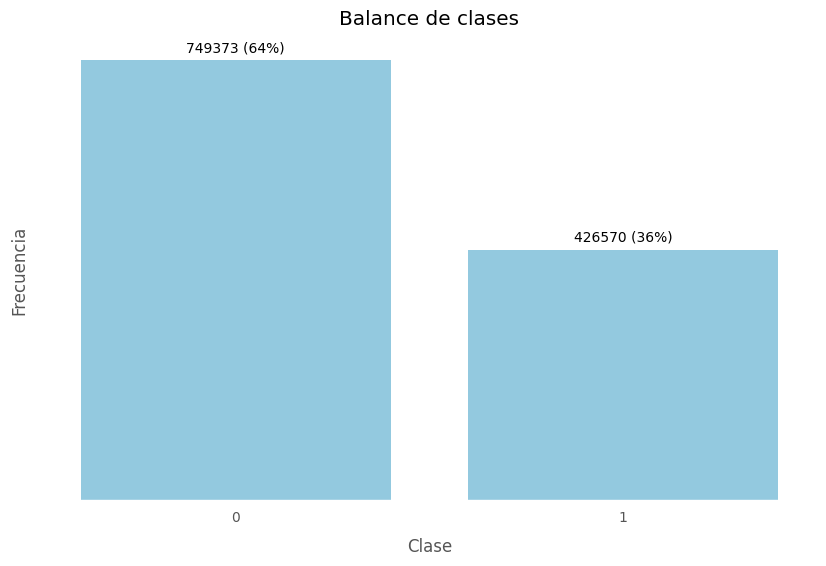

In [52]:
# Customized style
custom_style = {
    'axes.edgecolor': 'white',  # Axis layout color
    'axes.facecolor': 'white',  # Axias face color
    'grid.color': 'white',   # Grid lines color
}

plt.style.use('ggplot')  # Use ggplot as base
plt.rcParams.update(custom_style)  # Apply syle

# Gráfica de barras con seaborn
plt.figure(figsize=(10, 6)) # Tamaño de la figura
ax = sns.countplot(data=df_converted, x='CLASIFICACION_FINAL', color='skyblue') # Gráfica de barras
plt.title('Balance de clases', pad=10) # Título del gráfico
plt.xlabel('Clase', labelpad=10) # Etiqueta del eje x
plt.ylabel('Frecuencia', labelpad=10) # Etiqueta del eje y

# Desactivar las marcas en el eje x
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Eliminar los valores del eje y
ax.set_yticks([])

# Anotar los valores de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} ({round(p.get_height()/len(df_converted) *100)}%)', (p.get_x() + p.get_width() / 2., p.get_height() + 10000), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show() # Mostrar gráfico


Se debe de tomar en cuenta el desbalance de los datos a la hora de seleccionar el modelo y el algoritmo de aprendizaje. 

### Random Forest

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))

Matriz de confusión:
[[149410      0]
 [     0  85779]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149410
           1       1.00      1.00      1.00     85779

    accuracy                           1.00    235189
   macro avg       1.00      1.00      1.00    235189
weighted avg       1.00      1.00      1.00    235189


Precisión del modelo: 1.0


In [31]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Inicializar la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo utilizando la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
best_rf_classifier = grid_search.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))
